In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_datareader as pdr
import datetime as dt
import statsmodels.formula.api as smf
import statsmodels.api as sm

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess


# <font face="gotham" color="purple"> ARMA And ARIMA </font>

We have introduced $\text{AR}$ and $\text{MA}$ models in previous chapters, here we will continue to introduce other two common models: $\text{ARMA}$ and $\text{ARMIA}$.

An $\text{ARMA}(1,1)$ process is a combination of $\text{AR}$ and $\text{MA}$
$$
Y_{t}=\phi_0+\phi_{1} Y_{t-1}+\theta_{0} u_{t}+\theta_{1} u_{t-1}
$$

In general, $\text{ARMA}(p,q)$ process has the form
$$
Y_t = \phi_0 + \phi_i\sum_{i=1}^pY_{t-i}+\sum_{i=1}^q\theta_i u_{t-i}
$$

And $\text{ARIMA}$ model is essentially the same as $\text{ARMA}$, if we have to difference a series $d$ times to render it stationary then apply the $\text{ARIMA}$ model, we say that the original time series is $\text{ARIMA}(p,d,q)$. 

With the same token, $\text{ARIMA}(p,0,q)$ process is the same as $\text{ARMA}(p,q)$.

# <font face="gotham" color="purple"> The Box-Jenkins Methodology </font>

With so many options at hands, what model to apply to a time series? This is where **Box-Jenkins Methodology** kick in, which provides a systematic method of **identifying**, **estimating** and **checking** with $\text{ARIMA}$ models. 

## <font face="gotham" color="purple"> ACF VS PACF </font>

Before discussion of $\text{ARIMA}$ identification, we should understand the difference of **autocorrelation function** (ACF) and **partial autocorrelation function** (PACF), which both are important tools for identifying lags of $\text{ARIMA}$.

We have shown that the formula of sample ACF
\begin{aligned}
&\hat{\gamma}_{k}=\frac{\sum\left(Y_{t}-\bar{Y}\right)\left(Y_{t+k}-\bar{Y}\right)}{n-k} \\
&\hat{\gamma}_{0}=\frac{\sum\left(Y_{t}-\bar{Y}\right)^{2}}{n-1}\\
&\hat{\rho}_{k} =\frac{\hat{\gamma}_{k}}{\hat{\gamma}_{0}}=\frac{\text { covariance at lag } k}{\text { variance }}
\end{aligned}

However, PACF doesn't have a formula. Simply speaking, PACF requires removing all correlations in between. e.g. if you are measuring variables $k$ periods apart, then all influences from other variables in period $<k$ should be eliminated.

Regression with demeaned variables can give us the partial autocorrelation, e.g. 
$$
y_t-\bar{y}=\phi_{21} (y_{t-1}-\bar{y})+\phi_{22} (y_{t-2}-\bar{y})+\phi_{33} (y_{t-3}-\bar{y})+u_{t}
$$
Estimates of $\phi_{kk}$ is the partial correlation at lag $3$.

So how to use ACF and PACF to identify the lags of $\text{ARMA}$ model? First we transform the original data into log difference, then plot both correlograms. 

In [140]:
start = dt.datetime(1980, 1, 1)
end = dt.datetime(2021,10, 1)
df_cpi = pdr.data.DataReader(['CPIAUCSL'], 'fred' , start, end)
df_cpi.columns = ['urban_CPI']
df_cpi = df_cpi.dropna()

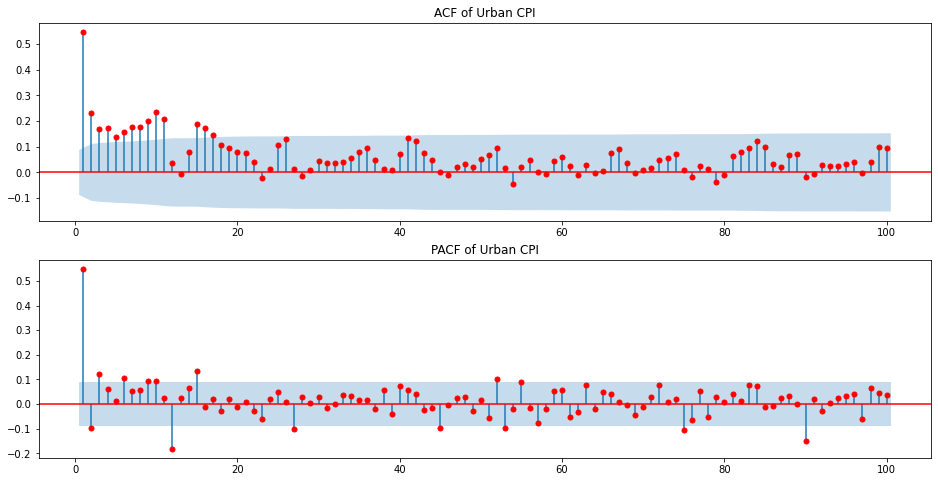

In [141]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(16,8))
acf_cpi = plot_acf(np.log(df_cpi).diff().dropna(), ax=ax[0],
         lags=100, color = 'red', zero = False, 
         title ='ACF of Urban CPI')
pacf_cpi = plot_pacf(np.log(df_cpi).diff().dropna(), ax=ax[1],
          lags=100, color = 'red', zero = False, 
          title ='PACF of Urban CPI')

## <font face="gotham" color="purple"> Simulation of ACF and PACF </font>

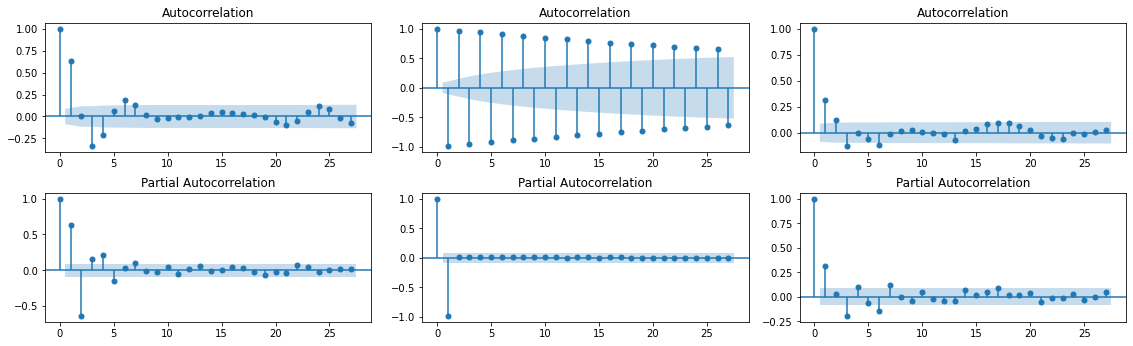

In [161]:
arparams = np.array([[.63, -.5], 
                     [-.23, .8],
                     [-.5, -.5]])
maparams = np.array([[.58, .45],
                     [.78, .34],
                     [.8, .8]])

fig, ax = plt.subplots(nrows = 2, ncols = 3, figsize = (16, 5))
fig.tight_layout(pad=2.0)
ar = np.r_[1, -arparams[0]]
ma = np.r_[1, maparams[0]]
arma22 = ArmaProcess(ar, ma).generate_sample(nsample=500)
acf = plot_acf(arma22, ax = ax[0, 0])
pacf = plot_pacf(arma22, ax = ax[1, 0])

ar = np.r_[1, -arparams[1]]
ma = np.r_[1, maparams[1]]
arma22 = ArmaProcess(ar, ma).generate_sample(nsample=500)
acf = plot_acf(arma22, ax = ax[0, 1])
pacf = plot_pacf(arma22, ax = ax[1, 1])

ar = np.r_[1, -arparams[2]]
ma = np.r_[1, maparams[2]]
arma22 = ArmaProcess(ar, ma).generate_sample(nsample=500)
acf = plot_acf(arma22, ax = ax[0, 2])
pacf = plot_pacf(arma22, ax = ax[1, 2])

$$
\left(1-\phi_{1}L-\ldots-\phi_{p}L^{p}\right)y_{t} =
        \left(1+\theta_{1}L+\ldots+\theta_{q}L^{q}\right)\varepsilon_{t}
$$

## <font face="gotham" color="purple"> Identification of ARMA </font>

The identification of $\text{ARMA}$ doesn't have clear-cut rules, but here are four guideline to help you decide the lags of $\text{ARMA}$ model.
1. If PACF shows significant lags through $p$ and ACF dampens exponentially, try $\text{AR}(p)$
2. If ACF shows significant lags through $q$ and PACF dampens exponentially, try $\text{MA}(q)$
3. Both ACF and PACF dampen exponentially with significant lags $(p, q)$, try $\text{ARMA}(p, q)$ 